In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

In [34]:
tickers = ['AAPL', 'MSFT']
index = 'SPY'

start_date = '2000-01-01'
end_date = '2016-12-31'

In [35]:
def load_prices(symbols, index, start_date, end_date):
    
    dates = pd.date_range(start_date, end_date)
    dfBase = pd.DataFrame(index = dates)
    
    dfIndex = pd.read_csv("C:/Users/A3/Desktop/Dados/{}.csv".format(index), index_col = "Date", parse_dates = True,
                     usecols = ['Date', 'Adj Close'], na_values=['nan'])
    dfIndex = dfIndex.dropna()
    dfIndex = dfIndex.rename(columns={'Adj Close': '{}'.format(index)})
    dfBase = dfBase.join(dfIndex, how = 'inner')
    
    
    for symbol in symbols:
        df_temp = pd.read_csv("C:/Users/A3/Desktop/Dados/{}.csv".format(symbol), index_col = "Date", parse_dates = True, 
                     usecols = ['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        dfBase = dfBase.join(df_temp)
    
    dfBase.fillna(method = "ffill", inplace = True) #Tratando dados 
    dfBase.fillna(method = "bfill", inplace = True)
    
    return dfBase #.drop(index,axis = 1) #Tiro o índice da tabela de preços...

In [36]:
data = load_prices(tickers, index, start_date, end_date)

In [37]:
data.describe()

,SPY,AAPL,MSFT
count,4277.000000,4277.000000,4277.000000
mean,114.103033,30.863950,25.932139
std,40.082269,36.514536,9.869913
min,55.535107,0.627570,11.904654
25%,85.593948,2.397632,19.825972
50%,101.283997,13.044073,22.191887
75%,124.658699,51.926788,26.953028
max,217.967209,124.616013,61.171520


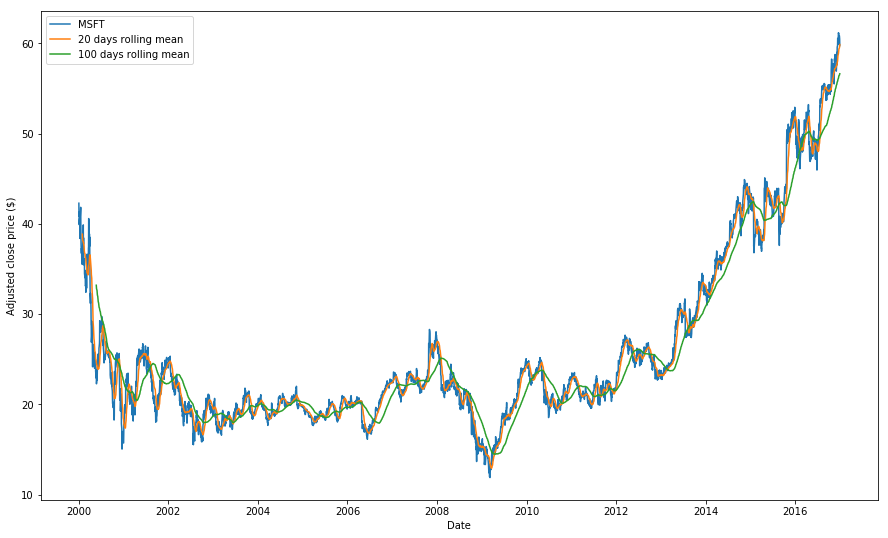

In [38]:
# Get the Microsoft timeseries.
msft = data.loc[:, 'MSFT']

# Calculate the 20 and the 100 days moving averages of the adjusted close price
short_rolling_msft = msft.rolling(window=20).mean()
long_rolling_msft = msft.rolling(window=100).mean()

# Plot ussing by matplotlib package
fig, ax =  plt.subplots(figsize=(15,9))

ax.plot(msft.index, msft, label='MSFT')
ax.plot(short_rolling_msft.index, short_rolling_msft, label='20 days rolling mean')
ax.plot(long_rolling_msft.index, long_rolling_msft, label='100 days rolling mean')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted close price ($)')
ax.legend()


In [39]:
# Calculate relative returns
returns = data.pct_change(1)
returns.head()

,SPY,AAPL,MSFT
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.039106,-0.084311,-0.033781
2000-01-05,0.001789,0.014634,0.010545
2000-01-06,-0.016071,-0.086539,-0.033498
2000-01-07,0.058076,0.047369,0.013068


In [40]:
# Calculate log returns
log_returns = np.log(data).diff()
log_returns.head()

,SPY,AAPL,MSFT
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.039891,-0.088078,-0.034364
2000-01-05,0.001787,0.014528,0.010489
2000-01-06,-0.016202,-0.090514,-0.034072
2000-01-07,0.056452,0.046281,0.012983


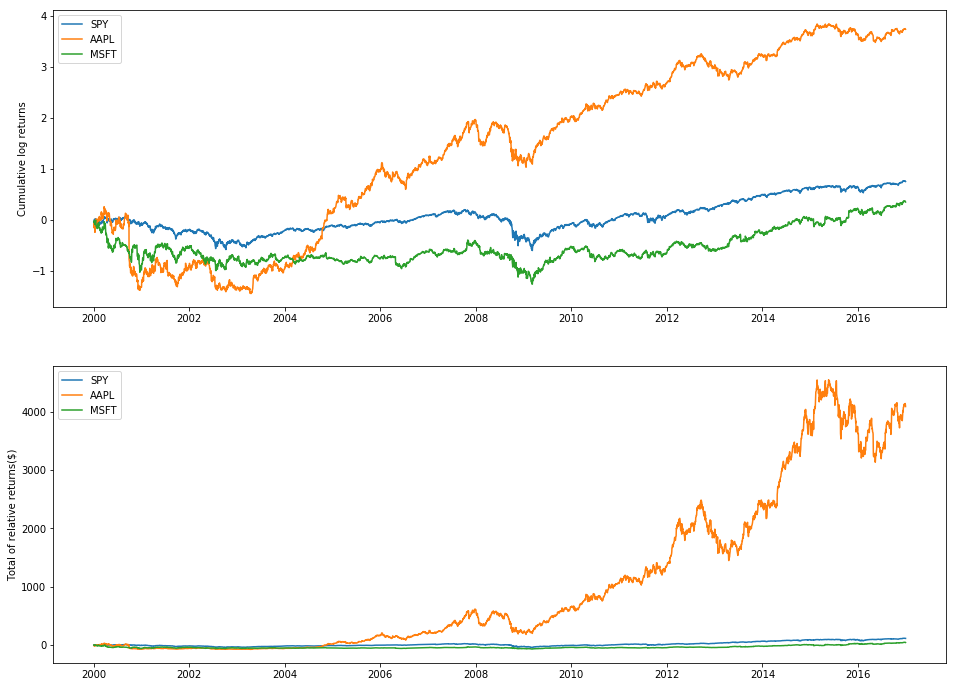

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc= 'best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum())-1), label=str(c))

ax2.set_ylabel('Total of relative returns($)')
ax2.legend(loc='best')

plt.show()

In [43]:
r_t = log_returns.tail(1).T
r_t

,2016-12-30 00:00:00
SPY,-0.003662
AAPL,-0.007826
MSFT,-0.012156


In [45]:
# Weights as define above
weigths_vector= pd.DataFrame(1/3, index=r_t.index, columns=r_t.columns)
weigths_vector

,2016-12-30 00:00:00
SPY,0.333333
AAPL,0.333333
MSFT,0.333333


In [46]:
# Total log_return for the portfolio is:
port_log_return = np.dot(weigths_vector.T,r_t)
port_log_return

array([[-0.00788148]])

In [53]:
weights_matrix = pd.DataFrame(1/3, index = data.index, columns=data.columns)
weights_matrix.tail()

,SPY,AAPL,MSFT
2016-12-23,0.333333,0.333333,0.333333
2016-12-27,0.333333,0.333333,0.333333
2016-12-28,0.333333,0.333333,0.333333
2016-12-29,0.333333,0.333333,0.333333
2016-12-30,0.333333,0.333333,0.333333


In [54]:
# Initially the two matrices are multiplied. Note that we are only interested in the diagonal, 
# which is where the dates in the row-index and the column-index match.
temp_var = weights_matrix.dot(log_returns.T)
temp_var.head().iloc[:, 0:5]

,2000-01-03 00:00:00,2000-01-04 00:00:00,2000-01-05 00:00:00,2000-01-06 00:00:00,2000-01-07 00:00:00
2000-01-03,NaN,-0.054111,0.008935,-0.046929,0.038572
2000-01-04,NaN,-0.054111,0.008935,-0.046929,0.038572
2000-01-05,NaN,-0.054111,0.008935,-0.046929,0.038572
2000-01-06,NaN,-0.054111,0.008935,-0.046929,0.038572
2000-01-07,NaN,-0.054111,0.008935,-0.046929,0.038572


In [55]:
# The numpy np.diag function is used to extract the diagonal and then
# a Series is constructed using the time information from the log_returns index
portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.tail()

2016-12-23   -0.000484
2016-12-27    0.003147
2016-12-28   -0.005722
2016-12-29   -0.000637
2016-12-30   -0.007881
dtype: float64

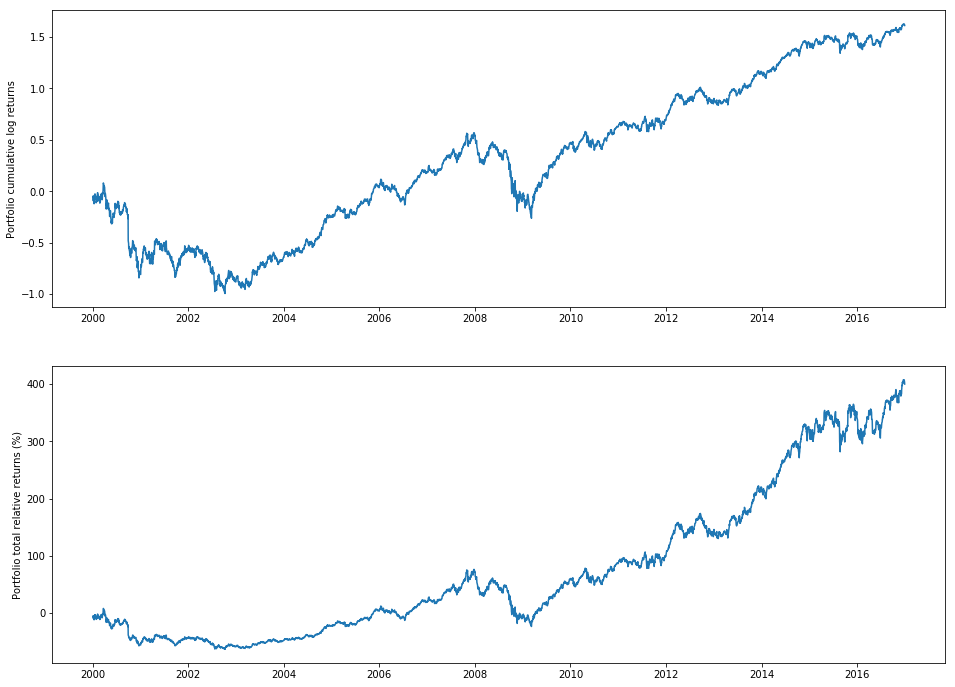

In [56]:
total_relative_returns = (np.exp(portfolio_log_returns.cumsum()) - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio cumulative log returns')

ax2.plot(total_relative_returns.index, 100 * total_relative_returns)
ax2.set_ylabel('Portfolio total relative returns (%)')

plt.show()

In [57]:
# Calculating the time-related parameters of the simulation
days_per_year = 52 * 5
total_days_in_simulation = data.shape[0]
number_of_years = total_days_in_simulation / days_per_year

# The last data point will give us the total portfolio return
total_portfolio_return = total_relative_returns[-1]
# Average portfolio return assuming compunding of returns
average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('Total portfolio return is: ' +
      '{:5.2f}'.format(100 * total_portfolio_return) + '%')
print('Average yearly return is: ' +
      '{:5.2f}'.format(100 * average_yearly_return) + '%')

Total portfolio return is: 400.22%
Average yearly return is: 10.28%


# Moving Average strategy

In [62]:
# Calculating the simple moving avarege of data
short_rolling = data.rolling(window=20).mean()
short_rolling.tail()

,SPY,AAPL,MSFT
2016-12-23,214.775091,109.955970,59.379737
2016-12-27,215.115956,110.231826,59.508099
2016-12-28,215.346236,110.488774,59.599443
2016-12-29,215.599471,110.789840,59.726363
2016-12-30,215.851997,111.096723,59.867705


In [63]:
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()

,SPY,AAPL,MSFT
2016-12-23,207.978367,107.909344,56.416743
2016-12-27,208.095900,108.025027,56.480474
2016-12-28,208.178577,108.120330,56.536006
2016-12-29,208.262011,108.206758,56.589724
2016-12-30,208.336313,108.280117,56.634806


In [ ]:
fig, ax - plt.subplots(figsize=(16,9))

ax.plot(data.index, data['MSFT'], label='Price')
ax.plot(long_rolling.index, data['MSFT'], label='Price')